In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [35]:
import re
import os
import pandas as pd
import numpy as np
import sklearn
import math
import scipy
import matplotlib.pyplot as plt
import pickle
import operator
import skmisc
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, PredefinedSplit, StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from scipy.stats import skew
from math import sqrt
from IPython.display import display
from pdpbox import pdp
from plotnine import *
import xgboost as xgb
import eli5 #show_weights, explain_weights_xgboost, permutation_importance

In [3]:
DATA_PATH = "data/"

In [4]:
os.listdir(DATA_PATH)

['df_merged_clean.pkl',
 '.DS_Store',
 'sub_xgboost.csv',
 'survived.frt',
 'test.csv',
 'survived.pkl',
 'infos_passengers',
 'df_merged.pkl',
 'sub_keras.csv',
 'sub1.csv',
 'train.csv',
 'sub_keras_2.csv',
 'df_merged.frt',
 'sub_keras_3.csv',
 'infose_passengers']

# Loading Data

In [5]:
df_train_raw = pd.read_csv(f"{DATA_PATH}train.csv")
df_test_raw = pd.read_csv(f"{DATA_PATH}test.csv")

In [6]:
df_train_raw.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [7]:
display(df_train_raw.head())
display(df_test_raw.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
df_train_raw["Sex"] = df_train_raw["Sex"].astype("category")
df_test_raw["Sex"] = df_test_raw["Sex"].astype("category")
df_train_raw["Embarked"] = df_train_raw["Embarked"].astype("category")
df_test_raw["Embarked"] = df_test_raw["Embarked"].astype("category")
df_train_raw.Embarked.cat.rename_categories(["Cherbourg", "Queenstown", "Southampton"], inplace=True)
df_test_raw.Embarked.cat.rename_categories(["Cherbourg", "Queenstown", "Southampton"], inplace=True)

In [9]:
survived = df_train_raw["Survived"]
df_merged = pd.concat([df_train_raw.drop("Survived", axis=1), df_test_raw])

In [10]:
df_merged.shape

(1309, 11)

In [11]:
df_merged.to_pickle(f"{DATA_PATH}df_merged.pkl")
survived.to_pickle(f"{DATA_PATH}survived.pkl")

# Missing values

In [12]:
df_merged = pd.read_pickle(f"{DATA_PATH}df_merged.pkl")

In [13]:
def missing_values_stats(df, keep_zeros=False):
    """
        The function return stats on the missing values in the dataframe.
        
        Inputs:
            df: dataframe to analyze
            keep_zeros: boolean to specify if the columns with zeros missing values are kept in the stats.
        
        Outputs:
            res: A data frame containing for each columns of df the total of missing values and the percetage.
        
    """
    res = pd.DataFrame()
    res["Total"] = df.isnull().sum().sort_values(ascending=False)
    res["Percentage"] = np.round((res["Total"]/len(df))*100, 2)
    if not keep_zeros:
        res = res.loc[res.Total > 0, ["Total", "Percentage"]]
    return res

In [14]:
missing_values_stats(df_merged)

,Total,Percentage
Cabin,1014,77.46
Age,263,20.09
Embarked,2,0.15
Fare,1,0.08


## Fare missing value

In [15]:
df_merged[df_merged.Fare.isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,Southampton


In [16]:
# Look if an other passenger is on the ticket
df_merged[df_merged.Ticket == "3701"]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,Southampton


median:  13.0


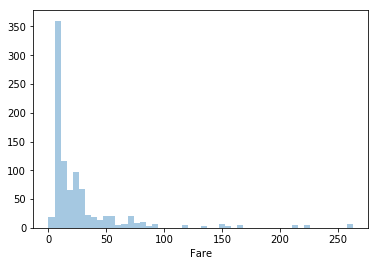

In [17]:
# Look at the fare distribution for passengers from Southampton
sns.distplot(df_merged[df_merged.Embarked == "Southampton"]["Fare"].dropna(), kde=False)
print("median: ", df_merged[df_merged.Embarked == "Southampton"]["Fare"].dropna().median())

In [18]:
df_merged.loc[df_merged.Fare.isna(), "Fare"] = 13

In [19]:
missing_values_stats(df_merged)

,Total,Percentage
Cabin,1014,77.46
Age,263,20.09
Embarked,2,0.15


In [20]:
df_merged["Fare"].skew()

4.3694583955715363

In [21]:
# Reduce skewness
df_merged["Fare"] = np.log1p(df_merged["Fare"])

## Missing Embarked values

In [22]:
df_merged[df_merged.Embarked.isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,4.394449,B28,NaN
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,4.394449,B28,NaN


In [23]:
# Both are on the same ticket, is there other passengers on it ?
df_merged[df_merged.Ticket == "113572"]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,4.394449,B28,NaN
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,4.394449,B28,NaN


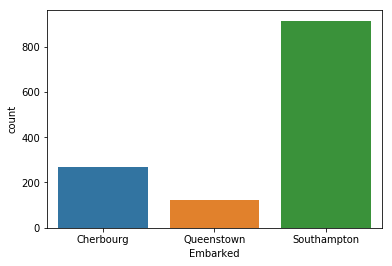

In [24]:
sns.countplot(df_merged["Embarked"].dropna())

In [25]:
# We assume that their both embarked in Southampton
df_merged.loc[df_merged.Embarked.isna(), "Embarked"] = "Southampton"

In [26]:
missing_values_stats(df_merged)

,Total,Percentage
Cabin,1014,77.46
Age,263,20.09


## Age missing values

In [27]:
df_merged[df_merged.Age.isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,2.246893,NaN,Queenstown
17,18,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,2.639057,NaN,Southampton
19,20,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,2.107178,NaN,Cherbourg
26,27,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,2.107178,NaN,Cherbourg
28,29,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,2.183711,NaN,Queenstown
29,30,3,"Todoroff, Mr. Lalio",male,NaN,0,0,349216,2.185579,NaN,Southampton
31,32,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,4.993969,B78,Cherbourg
32,33,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,2.169054,NaN,Queenstown
36,37,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,2.107689,NaN,Cherbourg
42,43,3,"Kraeff, Mr. Theodor",male,NaN,0,0,349253,2.185579,NaN,Cherbourg


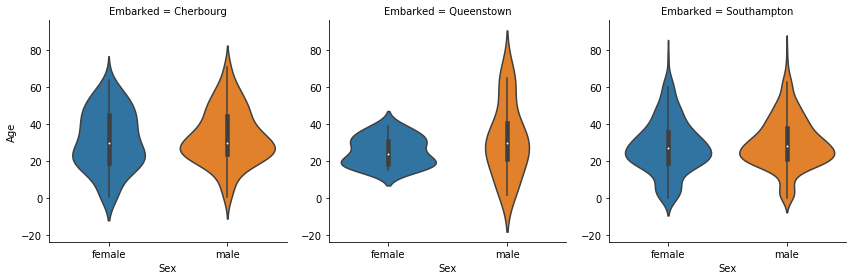

In [28]:
sns.factorplot(x="Sex", y="Age", col="Embarked", data=df_merged[df_merged.Age.isna() == False], kind="violin")

In [29]:
std = df_merged[(df_merged.Sex == "female") & (df_merged.Embarked == "Cherbourg")]["Age"].dropna().std()
mean = df_merged[(df_merged.Sex == "female") & (df_merged.Embarked == "Cherbourg")]["Age"].dropna().mean()
skew = df_merged[(df_merged.Sex == "female") & (df_merged.Embarked == "Cherbourg")]["Age"].dropna().skew()
mean, std, skew

(31.224489795918366, 15.834985481550833, 0.035840432474701318)

In [30]:
for s in df_merged["Sex"].cat.categories:
    for e in df_merged["Embarked"].cat.categories:
#        print("mean: ", df_merged[(df_merged.Sex == s) & (df_merged.Embarked == e)]["Age"].dropna().mean())
#        print("std: ", df_merged[(df_merged.Sex == s) & (df_merged.Embarked == e)]["Age"].dropna().std())
        print("skew: ", df_merged[(df_merged.Sex == s) & (df_merged.Embarked == e)]["Age"].dropna().skew())

skew:  0.0358404324747
skew:  0.266133833483
skew:  0.386225220433
skew:  0.381310587244
skew:  0.477414495447
skew:  0.470933833068


In [31]:
# The skews of the distributions are small, so we'll fill missing values with random values from a normal distributions
for s in df_merged["Sex"].cat.categories:
    for e in df_merged["Embarked"].cat.categories:
        mean = df_merged[(df_merged.Sex == s) & (df_merged.Embarked == e)]["Age"].dropna().mean()
        std = df_merged[(df_merged.Sex == s) & (df_merged.Embarked == e)]["Age"].dropna().std()
        size = df_merged[(df_merged.Sex == s) & (df_merged.Embarked == e)]["Age"].isna().sum()
        df_merged.loc[(df_merged.Sex == s) & (df_merged.Embarked == e) & (df_merged.Age.isna()), "Age"] = np.random.normal(mean, std, size)

In [32]:
df_merged.loc[df_merged.Age < 0, "Age"] = 0

In [33]:
for s in df_merged["Sex"].cat.categories:
    for e in df_merged["Embarked"].cat.categories:
        print("skew: ", df_merged[(df_merged.Sex == s) & (df_merged.Embarked == e)]["Age"].dropna().skew())

skew:  0.0195650280236
skew:  0.185594454453
skew:  0.415004635478
skew:  0.336408492388
skew:  0.292700733658
skew:  0.390003410587


In [34]:
missing_values_stats(df_merged)

,Total,Percentage
Cabin,1014,77.46


# Features engineering

## is alone ?

In [35]:
df_merged.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [36]:
df_merged.reset_index(drop=True, inplace=True)

In [37]:
res = []
for i in range(0, len(df_merged)):
    ticket = df_merged.loc[i, "Ticket"]
    res.append(len(df_merged[df_merged.Ticket == ticket]))

In [38]:
df_merged["PassengerPerTicket"] = res

In [39]:
df_merged["isAlone"] = (df_merged["Parch"] + df_merged["SibSp"] + df_merged["PassengerPerTicket"] - 1) == 0

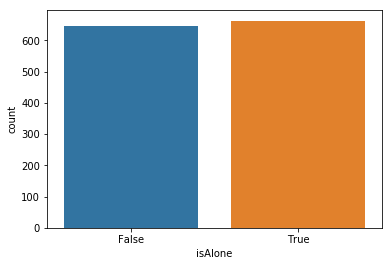

In [40]:
sns.countplot(df_merged["isAlone"])

## group size

In [41]:
# Person on the ticket but not in the family
res = []
for i in range(0, len(df_merged)):
    family_name = df_merged.loc[i, "Name"].split(",")[0]
    ticket = df_merged.loc[i, "Ticket"]
    tmp = df_merged[df_merged.Ticket == ticket]
    res.append((tmp["Name"].apply(lambda x: x.split(",")[0]) != family_name).sum())

In [42]:
df_merged["GroupSize"] = df_merged["SibSp"] + df_merged["Parch"] + res

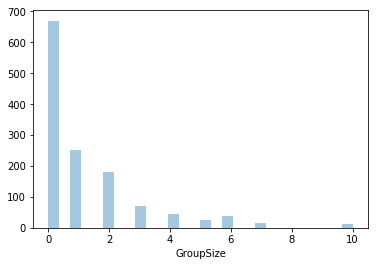

In [43]:
sns.distplot(df_merged["GroupSize"], kde=False)

In [44]:
df_merged.to_pickle(f"{DATA_PATH}df_merged_clean.pkl")

# XGBoost Model

In [5]:
df_merged = pd.read_pickle(f"{DATA_PATH}df_merged_clean.pkl")
survived = pd.read_pickle(f"{DATA_PATH}survived.pkl")

In [6]:
df_merged = df_merged.join(pd.get_dummies(df_merged["Embarked"], prefix="Embarked"))
df_merged["Sex"] = df_merged.Sex.cat.codes

In [7]:
keep_feats = ["Pclass", "Age", "Fare", "isAlone",
              "GroupSize", "Embarked_Cherbourg", "Embarked_Queenstown", "Embarked_Southampton",
             "Sex"]

In [8]:
df_train = df_merged[:survived.shape[0]].copy()
df_test = df_merged[survived.shape[0]:].copy()

In [9]:
def get_scores(model):
    return {"mean": model.cv_results_["mean_test_score"][0], "std": model.cv_results_["std_test_score"][0]}

In [10]:
params = {}
n_folds = 10
XGB = xgb.XGBClassifier()
model = GridSearchCV(XGB, params, cv=n_folds, refit=True)
model.fit(df_train[keep_feats], survived)
get_scores(model)

{'mean': 0.8204264870931538, 'std': 0.036311904302102474}

In [11]:
pred = model.predict(df_test[keep_feats])
pd.DataFrame({"PassengerId": df_test["PassengerId"], "Survived":pred}).to_csv(f"{DATA_PATH}sub_xgboost.csv", index=False)

Score of **0.74641** on the kaggle public leaderboard.

## Model evaluation

In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score

### Confusion matrix

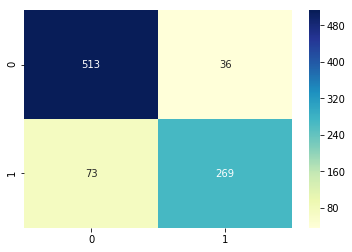

In [13]:
y_pred = model.predict(df_train[keep_feats])
confusion_matrix(survived, y_pred)
sns.heatmap(confusion_matrix(survived, y_pred), annot=True, fmt="", cmap="YlGnBu")

* **513** passengers **correctly predicted** as dead, and **36** passengers **wrongly classified** as survived (false-positive).
* **269** passengers **correctly predicted** as alive, and **73** passengers **wrongly classified** as alive (false-negative).

### Precision and recall

In [14]:
print("Precision:", precision_score(survived, y_pred))
print("Recall:",recall_score(survived, y_pred))

Precision: 0.8819672131147541
Recall: 0.7865497076023392


* The model predicted the survival of the passengers with a precision of 88%.
* The recall tells us that the model predicted the survival of ~59 % of the people who actually survived.

### F1 score

In [15]:
print("f1 score: ", f1_score(survived, y_pred))

f1 score:  0.8315301391035549


### ROC curve

In [23]:
y_scores = model.predict_proba(df_train[keep_feats])[..., 1]

In [25]:
print("ROC-AUC-Score:", roc_auc_score(survived, y_scores))

ROC-AUC-Score: 0.9387216523397139


Pretty good score.

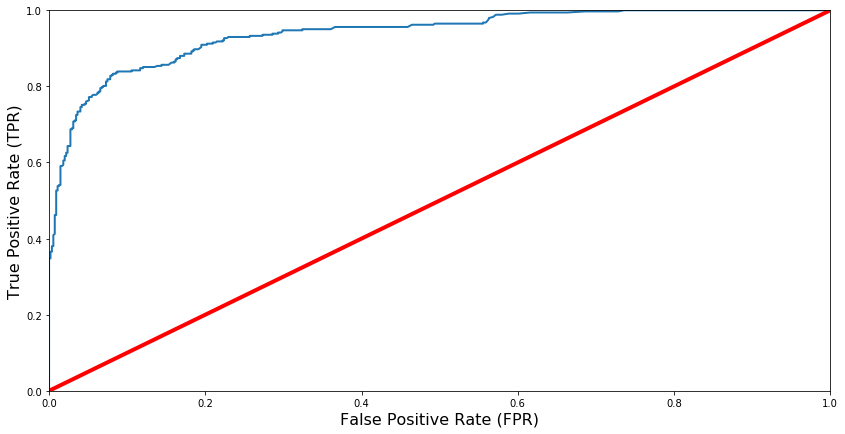

In [24]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(survived, y_scores)
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

## Model interpretation
### Features importance

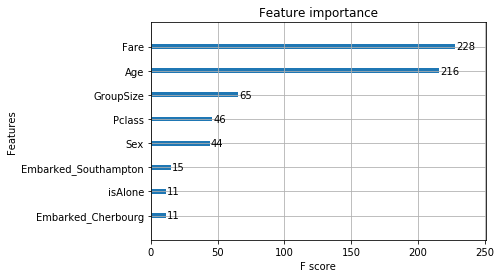

In [80]:
xgb.plot_importance(model.best_estimator_)

The model is mostly driven by the fare and the age of the passenger.

### Partial dependance plots

In [81]:
from pdpbox import pdp

In [82]:
df_train[keep_feats] = df_train[keep_feats].astype(np.float64)

#### Sex

In [88]:
pdp_sex = pdp.pdp_isolate(model, df_train[keep_feats], "Sex")

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x11387f780>>
Traceback (most recent call last):
  File "/Users/bastien/anaconda3/lib/python3.6/site-packages/xgboost/core.py", line 368, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x110c5eb00>>
Traceback (most recent call last):
  File "/Users/bastien/anaconda3/lib/python3.6/site-packages/xgboost/core.py", line 368, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


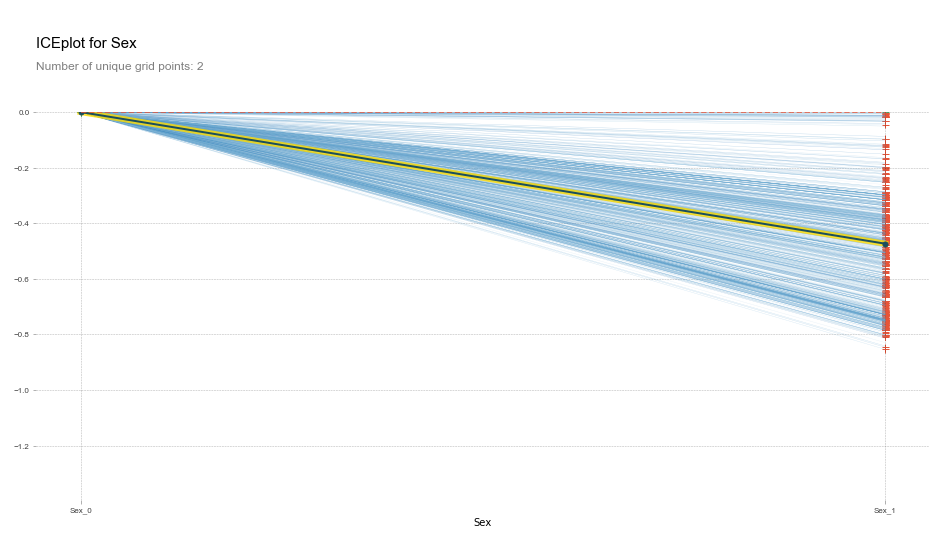

In [89]:
pdp.pdp_plot(pdp_sex, "Sex", plot_org_pts=True, plot_lines=True, frac_to_plot=1)

From the graph above we can conclude that being a male decrease the chance to survived with this model.

#### Fare

In [91]:
pdp_fare = pdp.pdp_isolate(model, df_train[keep_feats], "Fare")

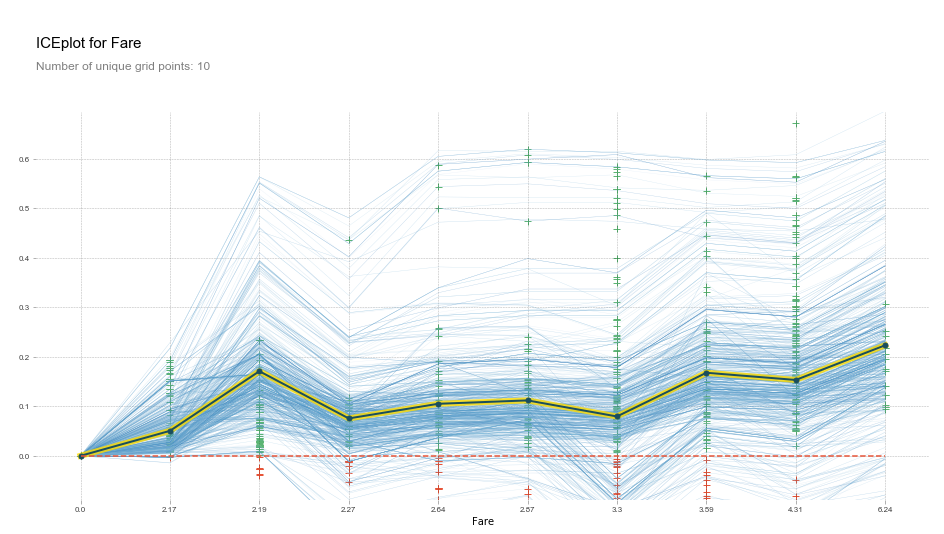

In [119]:
pdp.pdp_plot(pdp_fare, "Fare", plot_org_pts=True, plot_lines=True, frac_to_plot=1, x_quantile=True)

Let reminds that we took the log of the Fare to reduce the skewness of the distribution. 
From the graph above we can conclude that having a low Fare (< 2.17) reduce the change of surviving. 

#### Age

In [94]:
pdp_age = pdp.pdp_isolate(model, df_train[keep_feats], "Age")

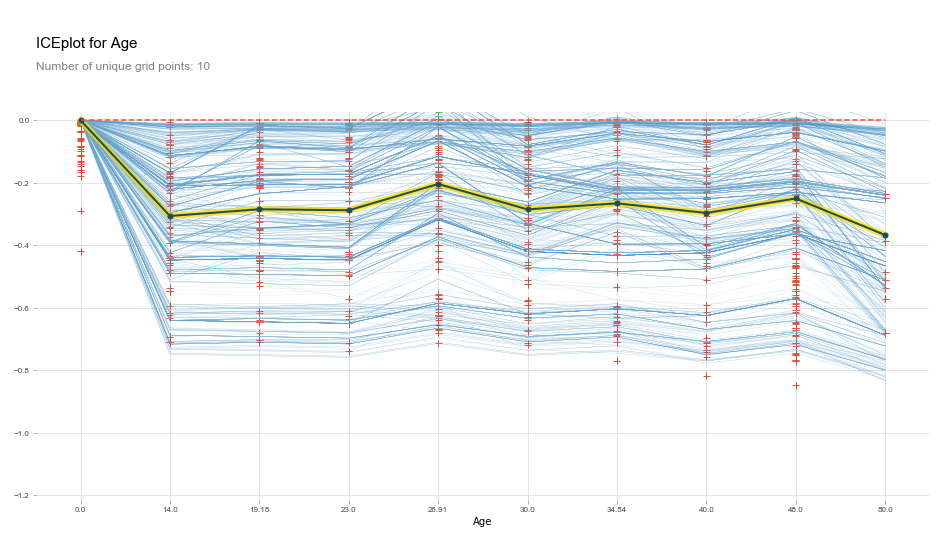

In [103]:
pdp.pdp_plot(pdp_age, "Age", plot_org_pts=True, plot_lines=True, frac_to_plot=1,
             x_quantile=True)

From the graph above we can conclude that being a children greatly improve your chance of surviving, wich is comfirm by the two graphs below.
However, for the range 14 to 45, the age does not seems to have a huge impact on the chance of surviving, in this range the sex should be more important.

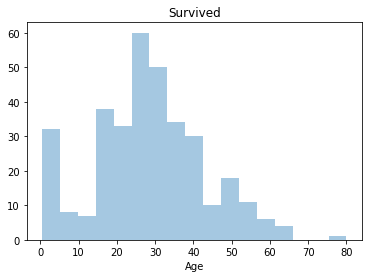

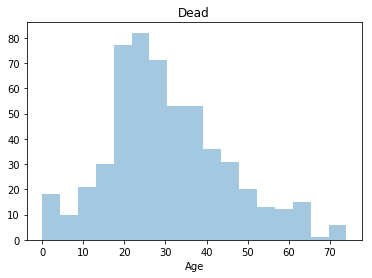

In [114]:
sns.distplot(df_train.loc[survived == 1, "Age"], kde=False)
plt.title("Survived")
plt.show()
sns.distplot(df_train.loc[survived == 0, "Age"], kde=False)
plt.title("Dead")
plt.show()

#### GroupSize

In [120]:
pdp_gps = pdp.pdp_isolate(model, df_train[keep_feats], "GroupSize")

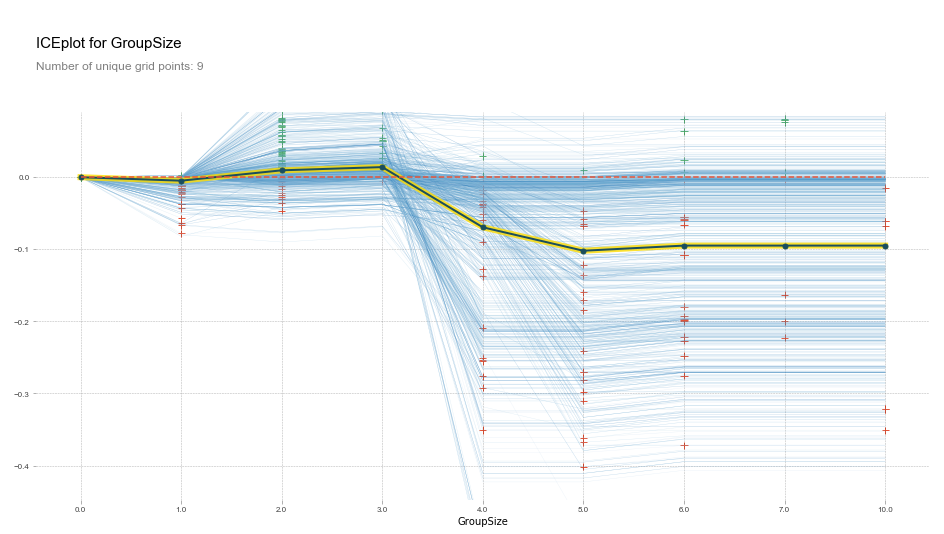

In [121]:
pdp.pdp_plot(pdp_gps, "GroupSize", plot_org_pts=True, plot_lines=True, frac_to_plot=1,
             x_quantile=True)

From the graph above we can deduce, that it slightly help to be with a small group, but being in a group of 4 and more decrease your change of surviving.
Maybe the passengers in a larger group were looking for all the members, more if family, before boarding saving boats.

#### Pclass

In [122]:
pdp_pclass = pdp.pdp_isolate(model, df_train[keep_feats], "Pclass")

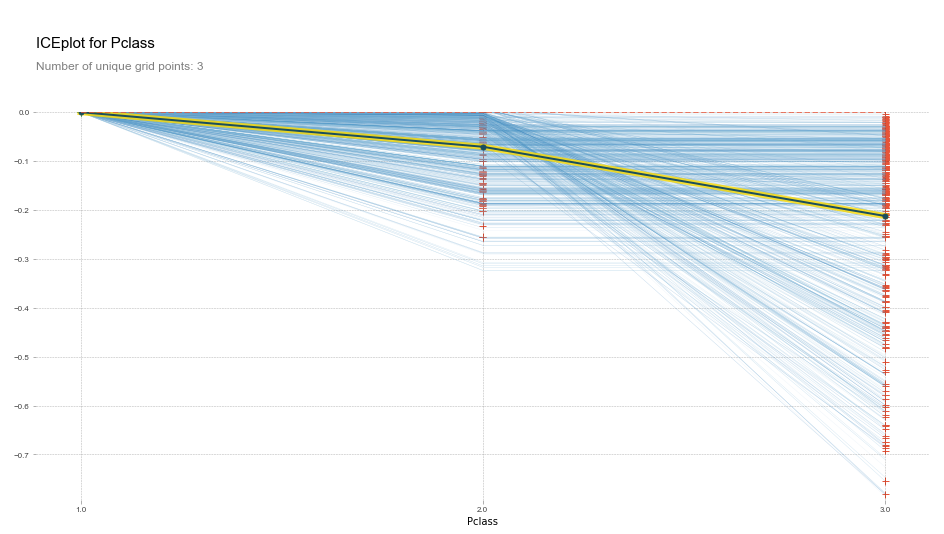

In [123]:
pdp.pdp_plot(pdp_pclass, "Pclass", plot_org_pts=True, plot_lines=True, frac_to_plot=1,
             x_quantile=True)

As espected the lower the passenger class, the lower chance of surviving.

# Keras
Let see if we can build a better model using deep learning.
We are using Keras, and implementing a simple dense network with entity embedding for categorical variables.

In [26]:
from keras.models import Sequential
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Activation, Reshape, Dropout
from keras.layers import Concatenate
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


## NN with embedings

In [63]:
from sklearn.metrics import precision_score

class NN_embeddings:
    def __init__(self, cat_feats, cat_feats_size, cont_feats, drop=0.5):
        self.cat_feats = cat_feats
        self.cont_feats = cont_feats
        
        self.inputs_cat = []
        self.outputs_cat = []
        for feat, size in zip(cat_feats, cat_feats_size):
            self.inputs_cat.append(Input(shape=(1,)))
            s = min(size, 50)
            out = Embedding(size, s, name=feat)(self.inputs_cat[-1])
            self.outputs_cat.append(Reshape(target_shape=(s,))(out))
        self.input_model = self.inputs_cat
        self.input_model.append(Input(shape=(len(cont_feats),)))
        
        self.output_model = Concatenate()(self.outputs_cat)
        self.output_model = Dense(1000, kernel_initializer="uniform")(self.output_model)
        self.output_model = Activation('relu')(self.output_model)
        self.output_model = Dropout(drop)(self.output_model)
        self.output_model = Dense(500, kernel_initializer="uniform")(self.output_model)
        self.output_model = Activation('relu')(self.output_model)
        self.output_model = Dropout(drop)(self.output_model)
        self.output_model = Dense(250, kernel_initializer="uniform")(self.output_model)
        self.output_model = Activation('relu')(self.output_model)
        self.output_model = Dropout(drop)(self.output_model)
        self.output_model = Dense(1)(self.output_model)
        self.output_model = Activation('sigmoid')(self.output_model)
        
        self.model = KerasModel(inputs=self.input_model, outputs=self.output_model)

        self.model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
        
    def prepare_input(self, _X):
        X = []
        for feat in self.cat_feats:
            X.append(_X[feat].values)
        X.append(_X[self.cont_feats].values)
        return X
    
    def prepare_input_shap(self, _X):
        X = []
        for i in range(len(self.cat_feats)):
            X.append(_X[..., i])
        X.append(_X[:, len(self.cat_feats):])
        return X
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        return precision_score(y, y_pred)
    
    def fit(self, X_train, y_train, X_valid, y_valid, epochs=50, batch_size=32, verbose=1):
        self.model.fit(self.prepare_input(X_train), y_train,
                       validation_data=(self.prepare_input(X_valid), y_valid),
                      epochs=epochs, batch_size=batch_size, verbose=verbose)
        print("Result on validation data: ", self.evaluate(X_valid, y_valid))
        
    def predict(self, X):
        y_pred = self.model.predict(self.prepare_input(X))
        return np.rint(y_pred.flatten()).astype(np.int)

    def predict_shap(self, X):
        y_pred = self.model.predict(self.prepare_input_shap(X))
        return np.rint(y_pred.flatten())
    
    def predict_proba(self, X):
        y_pred = self.model.predict(self.prepare_input(X))
        return y_pred
    

In [64]:
df_train.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'PassengerPerTicket', 'isAlone',
       'GroupSize', 'Embarked_Cherbourg', 'Embarked_Queenstown',
       'Embarked_Southampton', 'Embarked_code', 'Age_norm'],
      dtype='object')

In [65]:
df_train["Embarked_code"] = df_train.Embarked.cat.codes
df_test["Embarked_code"] = df_test.Embarked.cat.codes
# df_train["Pclass"] = df_train["Pclass"] - 1
# df_test["Pclass"] = df_test["Pclass"] - 1

In [66]:
cat_feats = ["Pclass", "Sex", "Embarked_code", "isAlone"]
cont_feats = ["Age", "Fare", "GroupSize"]
keep_feats_2 = [*cat_feats, *cont_feats]

In [67]:
print(keep_feats_2)

['Pclass', 'Sex', 'Embarked_code', 'isAlone', 'Age', 'Fare', 'GroupSize']


In [68]:
valid_size = np.int(np.round(len(df_train)*0.2))
X_valid, y_valid = df_train.loc[len(df_train)-valid_size:len(df_train), keep_feats_2], survived[len(df_train)-valid_size:len(df_train)]
X_train, y_train = df_train.loc[:len(df_train)-valid_size-1, keep_feats_2], survived[:len(df_train)-valid_size]
len(X_valid), len(y_valid), len(X_train), len(y_train)

(178, 178, 713, 713)

In [69]:
nn = NN_embeddings(cat_feats, [3, 2, 3, 2], cont_feats)
nn.fit(X_train, y_train, X_valid, y_valid, epochs=20, batch_size=32)

Train on 713 samples, validate on 178 samples
Epoch 1/20
713/713 [==============================] - 3s 4ms/step - loss: 0.6726 - acc: 0.6325 - val_loss: 0.6344 - val_acc: 0.7472
Epoch 2/20
713/713 [==============================] - 1s 2ms/step - loss: 0.5941 - acc: 0.7041 - val_loss: 0.4610 - val_acc: 0.8034
Epoch 3/20
713/713 [==============================] - 1s 2ms/step - loss: 0.4918 - acc: 0.7854 - val_loss: 0.4210 - val_acc: 0.8315
Epoch 4/20
713/713 [==============================] - 1s 2ms/step - loss: 0.4694 - acc: 0.7924 - val_loss: 0.4197 - val_acc: 0.8315
Epoch 5/20
713/713 [==============================] - 1s 2ms/step - loss: 0.4557 - acc: 0.7896 - val_loss: 0.4231 - val_acc: 0.8315
Epoch 6/20
713/713 [==============================] - 1s 2ms/step - loss: 0.4687 - acc: 0.7910 - val_loss: 0.4205 - val_acc: 0.8315
Epoch 7/20
713/713 [==============================] - 1s 2ms/step - loss: 0.4649 - acc: 0.8008 - val_loss: 0.4209 - val_acc: 0.8315
Epoch 8/20
713/713 [==========

In [47]:
preds = nn.predict(df_test[keep_feats_2])

In [48]:
pd.DataFrame({"PassengerId": df_test["PassengerId"], "Survived":preds}).to_csv(f"{DATA_PATH}sub_keras_3.csv", index=False)

The model scores **0.77990** on the kaggle public leaderboard.

## Evaluating the model

In [137]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score

### Confusion matrix

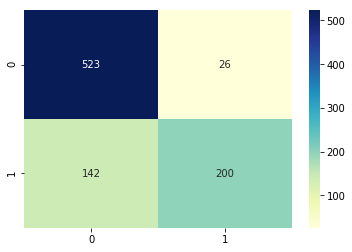

In [134]:
y_pred = nn.predict(df_train[keep_feats_2])
confusion_matrix(survived, y_pred)
sns.heatmap(confusion_matrix(survived, y_pred), annot=True, fmt="", cmap="YlGnBu")

* **523** passengers **correctly predicted** as dead, and **26** passengers **wrongly classified** as survived (false-positive).
* **200** passengers **correctly predicted** as alive, and **142** passengers **wrongly classified** as alive (false-negative).

### Precision and recall

In [135]:
print("Precision:", precision_score(survived, y_pred))
print("Recall:",recall_score(survived, y_pred))

Precision: 0.884955752212
Recall: 0.584795321637


* The model predicted the survival of the passengers with a precision of 88%.
* The recall tells us that the model predicted the survival of ~59 % of the people who actually survived.

### F1 score

In [138]:
print("f1 score: ", f1_score(survived, y_pred))

f1 score:  0.704225352113


In [154]:
y_scores = nn.predict_proba(df_train[keep_feats_2])

precision, recall, threshold = precision_recall_curve(survived, y_scores)

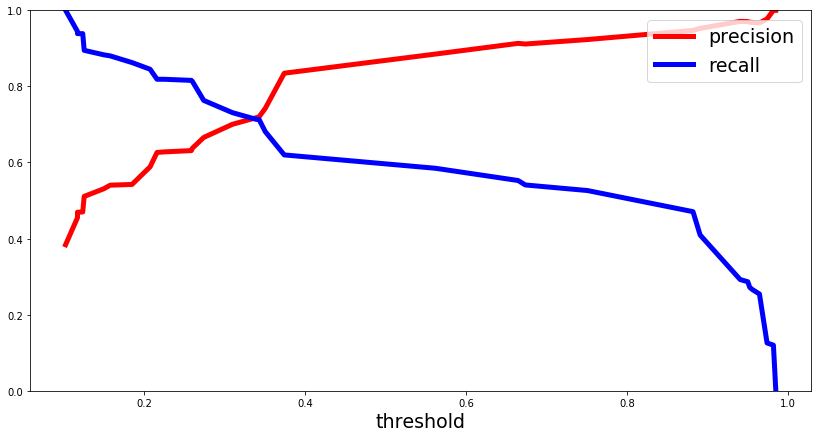

In [155]:
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

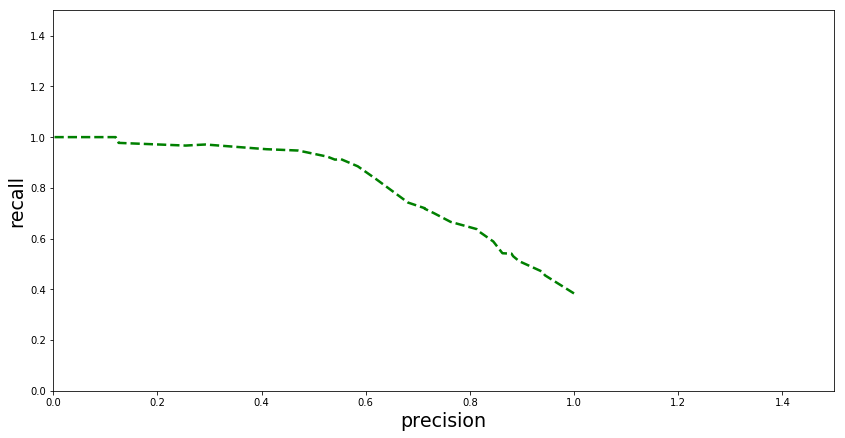

In [156]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, "g--", linewidth=2.5)
    plt.ylabel("recall", fontsize=19)
    plt.xlabel("precision", fontsize=19)
    plt.axis([0, 1.5, 0, 1.5])

plt.figure(figsize=(14, 7))
plot_precision_vs_recall(precision, recall)
plt.show()

### RAUC curve

In [157]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(survived, y_scores)

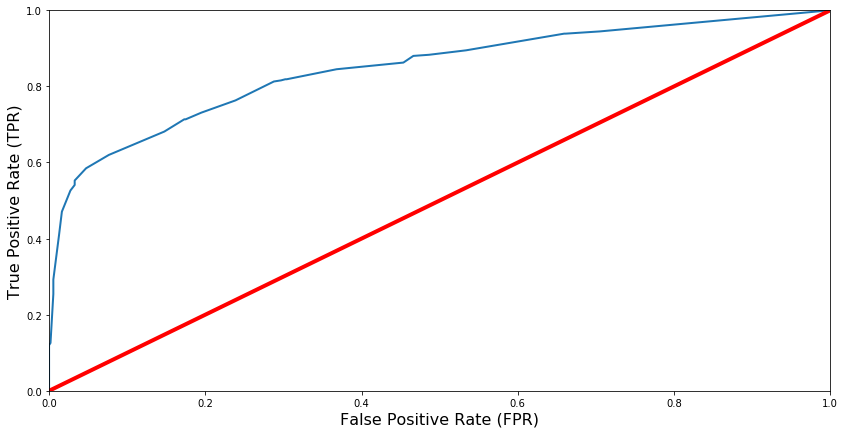

In [158]:
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

In [161]:
r_a_score = roc_auc_score(survived, y_scores)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.845801510455


## Embeddings analysis

In [60]:
from sklearn import manifold

### Sex embedding

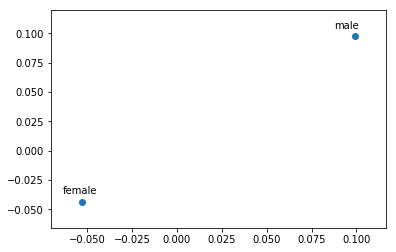

In [164]:
sex = ["female", "male"]
sex_embedding = nn.model.get_layer("Sex").get_weights()[0]
plt.scatter(sex_embedding[:, 0], sex_embedding[:, 1])
for i, txt in enumerate(sex):
    plt.annotate(txt, (sex_embedding[i, 0], sex_embedding[i, 1]), xytext = (-20, 8), textcoords = 'offset points')

### Pclass embedding

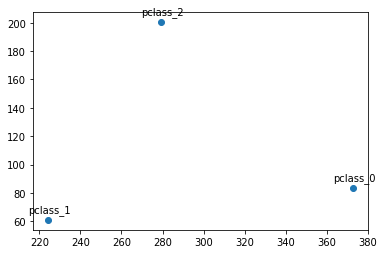

In [61]:
tsne = manifold.TSNE(init='pca', random_state=0, method='exact')
pclass_embedding = nn.model.get_layer("Pclass").get_weights()[0]
Y = tsne.fit_transform(pclass_embedding)
plt.scatter(Y[:, 0], Y[:, 1])
for i in range(3):
    plt.annotate("pclass_"+str(i), (Y[i, 0], Y[i, 1]), xytext = (-20, 8), textcoords = 'offset points')

### isAlone embedding

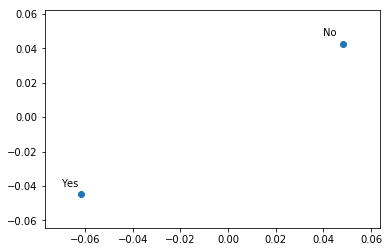

In [167]:
Y = nn.model.get_layer("isAlone").get_weights()[0]
plt.scatter(Y[:, 0], Y[:, 1])
for i, txt in enumerate(["Yes", "No"]):
    plt.annotate(txt, (Y[i, 0], Y[i, 1]), xytext = (-20, 8), textcoords = 'offset points')

### Embarked embedding

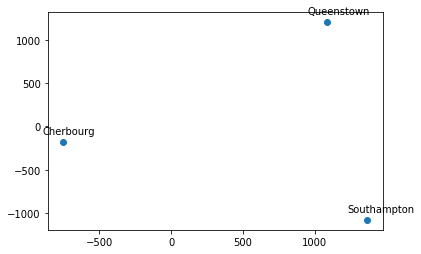

In [171]:
tsne = manifold.TSNE(init='pca', random_state=0, method='exact')
embarked_embedding = nn.model.get_layer("Embarked_code").get_weights()[0]
Y = tsne.fit_transform(embarked_embedding)
plt.scatter(Y[:, 0], Y[:, 1])
for i, txt in enumerate(df_test.Embarked.cat.categories.values):
    plt.annotate(txt, (Y[i, 0], Y[i, 1]), xytext = (-20, 8), textcoords = 'offset points')

# Understanding the model

In [70]:
import shap

In [71]:
shap.initjs()

In [72]:
nn.predict(df_test[keep_feats_2].iloc[:20, :])

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1])

In [73]:
explainer = shap.KernelExplainer(lambda x: nn.predict_shap(x), df_test[keep_feats_2].iloc[:200, :])
shap_values = explainer.shap_values(df_test[keep_feats_2].iloc[:200,:], nsamples=500)

100%|██████████| 200/200 [12:52<00:00,  3.86s/it]


In [74]:
shap.force_plot(shap_values[0,:], df_test[keep_feats_2].iloc[10,:])

In [75]:
shap.force_plot(shap_values, df_test[keep_feats_2].iloc[:200,:])

In [76]:
df_test[keep_feats_2] = df_test[keep_feats_2].astype(np.float64)

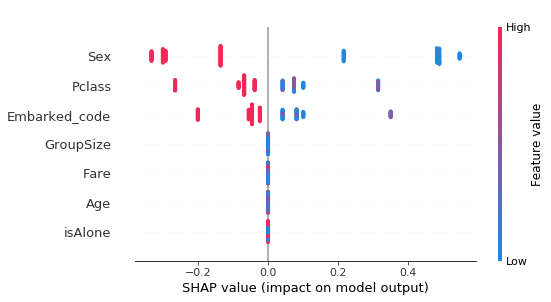

In [77]:
shap.summary_plot(shap_values, df_test[keep_feats_2].iloc[:200,:])

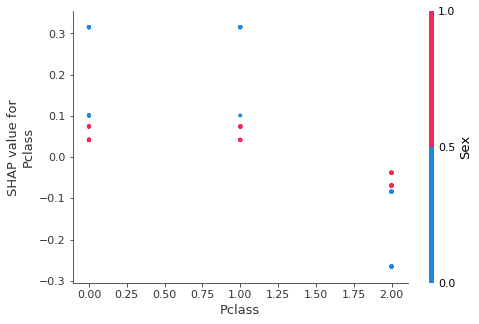

In [81]:
shap.dependence_plot("Pclass", shap_values, df_test[keep_feats_2].iloc[:200, :])